### Packages
Here I install and load the required packages and include the Simulation.jl and Neutron_fuctions.jl file as .SM and .NF.

This takes approximately 2.5 minutes.

In [81]:
Pkg.add(["DataFrames","CairoMakie","LinearAlgebra","StatsBase", "Interpolations","Distributions","Dates","Random","JLD","CSV"])
using DataFrames,CairoMakie,LinearAlgebra, StatsBase, Interpolations,Distributions,Dates,Random,JLD,CSV

TaskLocalRNG()

In [108]:
dir = "/Users/jbusink/Documents/GitHub/Neutronenbron_Simulatie/"
include(dir * "Scripts/light_theme.jl")
include(dir * "Scripts/Simulation.jl")
include(dir * "Scripts/Neutron_functions.jl")
using .SM, .NF

## Cross sections data
Here I calculate the cross-sections $\sigma$ as a function of the energie (left). The cross-section is given by:

$\sigma(E) = \sigma_{plateau} (E_0^2 / (E_0^2 + E^2) + E_T^2 / E^2)^{1/4}$,

with $E_0$ $4.5 10^4$ eV is an upper threshold energy above which the cross section decreases and $E_T$ the thermal cut-off energie. $E_T$ is the energie at which the neutrons are thermalized, with $E_T$ = 40meV.

In the right figure I calculate the distribution of the distances $P(d)$, using:

$P(d) = \frac{1}{\lambda_{MFP}}\exp({-d/\lambda_{MFP}})$,

with $\lambda_{MFP} = \frac{1}{n\sigma}$ the mean free path of the neutrons, n the number of hydrogen atoms and $\sigma$ the cross section of the (elastic or inelastic) scattering process.


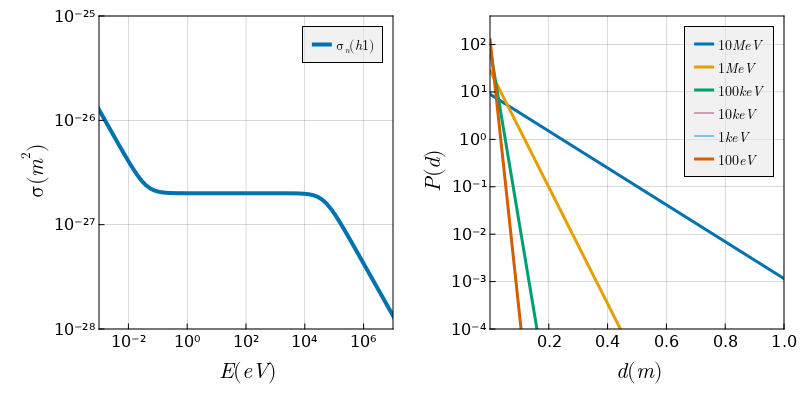

In [83]:
x = NF.logrange(-5,10,101)

fig = Figure(resolution=(800,400))

ax = Axis(fig[1, 1], 
xlabel = L"E (eV)", ylabel = L"\sigma (m^2)",
limits =(1e-3, 1e7,1e-28,1e-25), 
yscale=log10,xscale=log10
# xticks = 0:2:10,yticks=0.:0.2:0.6,
)

lines!(x, NF.cross_section_H1_SI.(x); linewidth = 4, label = L"\sigma_n(h1)")
axislegend(position = :rt, bgcolor = (:grey90, 0.55))

ax = Axis(fig[1,2],
xlabel = L"d (m)",ylabel=L"P(d)",
limits = (0.0001,1e0,0.0001,4e2),
yscale=log10,
# xscale=log10,
)
lines!(x,(1 ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e7))) .* exp.(-1 .* x ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e7)) ),label = L"10MeV",linewidth=3)
lines!(x,(1 ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e6))) .* exp.(-1 .* x ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e6)) ),label = L"1MeV",linewidth=3)
lines!(x,(1 ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e5))) .* exp.(-1 .* x ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e5)) ),label = L"100keV",linewidth=3)

lines!(x,(1 ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e4))) .* exp.(-1 .* x ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e4)) ),label = L"10keV")
lines!(x,(1 ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e3))) .* exp.(-1 .* x ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e3)) ),label = L"1keV")
lines!(x,(1 ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e2))) .* exp.(-1 .* x ./ NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e2)) ),label = L"100eV",linewidth=3)

axislegend(position = :rt, bgcolor = (:grey90, 0.55));

fig



In the next section I will use the data of the elastic and inelastic cross-sections (downloaded from https://wwwndc.jaea.go.jp/ENDF_Graph/). The data is converted to SI units $1e28 barn/m^2$ and changed to mm-scale $1000 mm/m$.

Note that, throughout the simulation we only use the data of the (in)elastic collision of Hydrogen. The data of the (in)elastic interaction with Oxygen is not used.

In [84]:
df_H1nn = NF.read_cross_section_data(dir*"Data/H1_elastic_scattering_sigma.rtf")
df_H1ngamma = NF.read_cross_section_data(dir*"Data/H1_fission_sigma.rtf")
df_O16nn = NF.read_cross_section_data(dir*"Data/O16_elastic_scattering_sigma.rtf")
df_O16ngamma = NF.read_cross_section_data(dir*"Data/O16_fission_sigma.rtf")

H1MFP(E) = 1000 .* NF.MFP(NF.n_protons,NF.cross_section_interpolated(dir*"Data/H1_elastic_scattering_sigma.rtf",E) ./ 1e28)
H1(x,E) = (1 ./ H1MFP(E)) .* exp.(-1 .* x ./ H1MFP(E))

H1γMFP(E) = 1000 .* NF.MFP(NF.n_protons,NF.cross_section_interpolated(dir*"Data/H1_fission_sigma.rtf",E) ./ 1e28)
H1γ(x,E) = (1 ./ H1γMFP(E)) .* exp.(-1 .* x ./ H1γMFP(E))

O16MFP(E) = 1000 .* NF.MFP(NF.n_oxygen,NF.cross_section_interpolated(dir*"Data/O16_elastic_scattering_sigma.rtf",E) ./ 1e28)
O16(x,E) = (1 ./ O16MFP(E)) .* exp.(-1 .* x ./ O16MFP(E))

O16γMFP(E) = 1000 .* NF.MFP(NF.n_oxygen,NF.cross_section_interpolated(dir*"Data/O16_fission_sigma.rtf",E) ./ 1e28)
O16γ(x,E) = (1 ./ O16γMFP(E)) .* exp.(-1 .* x ./ O16γMFP(E))


O16γ (generic function with 1 method)

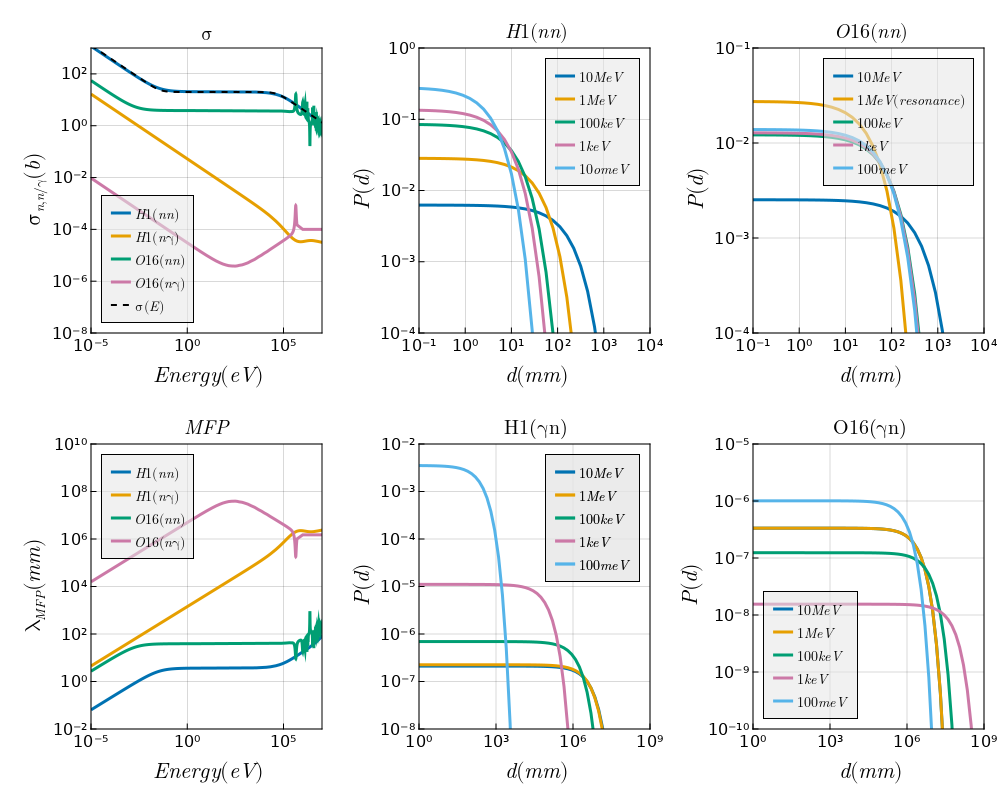

In [85]:
x = NF.logrange(-5,10,101)

fig = Figure(resolution=(1000,800))
axes =Axis(fig[1,1],
yscale = log10,xscale=log10,
xlabel = L"Energy (eV)", ylabel = L"\sigma_{n,n/\gamma}(b)",
xlabelsize=22,ylabelsize=22,
title= L"\sigma",titlesize=20,
limits=(1e-5,1e7,1e-8,1e3)
)

lines!(df_H1nn.Energy_ev,df_H1nn.cross_section_b,label = L"H1(nn)",linewidth=3)
lines!(df_H1ngamma.Energy_ev,df_H1ngamma.cross_section_b,label = L"H1(n\gamma)",linewidth=3)
lines!(df_O16nn.Energy_ev,df_O16nn.cross_section_b,label = L"O16(nn)",linewidth=3)
lines!(df_O16ngamma.Energy_ev,df_O16ngamma.cross_section_b,label = L"O16(n\gamma)",linewidth=3)
lines!(x, NF.cross_section_H1_SI.(x) .* 1e28; linewidth = 2, label = L"\sigma(E)",color=:black,linestyle=:dash)

axislegend(position = :lb, bgcolor = (:grey90, 0.55));


axes =Axis(fig[2,1],
yscale = log10,xscale=log10,
xlabel = L"Energy (eV)", ylabel = L"\lambda_{MFP} (mm)",
xlabelsize=22,ylabelsize=22,
title= L"MFP",titlesize=20,
limits=(1e-5,1e7,1e-2,1e10)
)

lines!(df_H1nn.Energy_ev,1000 ./ (df_H1nn.cross_section_b .* 2 .* NF.n_protons ./ 1e28),label = L"H1(nn)",linewidth=3)
lines!(df_H1ngamma.Energy_ev,1000 ./ (df_H1ngamma.cross_section_b .* 2 .* NF.n_protons ./ 1e28),label = L"H1(n\gamma)",linewidth=3)
lines!(df_O16nn.Energy_ev, 1000 ./ (df_O16nn.cross_section_b .* 1 .* NF.n_protons ./ 1e28),label = L"O16(nn)",linewidth=3)
lines!(df_O16ngamma.Energy_ev, 1000 ./ (df_O16ngamma.cross_section_b .* 1 .* NF.n_protons ./ 1e28),label = L"O16(n\gamma)",linewidth=3)
axislegend(position = :lt, bgcolor = (:grey90, 0.55));


ax = Axis(fig[1,2],
xlabel = L"d (mm)",ylabel=L"P(d)",
limits = (1e-1,1e4,1e-4,1e0),
yscale=log10,xscale=log10,
title= L"H1(nn)",titlesize=20
# xscale=log10,
)
lines!(x,H1(x,1e7),label = L"10MeV",linewidth=3)
lines!(x,H1(x,1e6),label = L"1MeV",linewidth=3)
# lines!(x,(1 ./ (1000 .* NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e6))) ).* exp.(-1 .* x ./ (1000 .* NF.MFP(NF.n_protons,NF.cross_section_H1_SI(1e6))) ),label = L"10MeV",linewidth=1)
lines!(x,H1(x,1e5),label = L"100keV",linewidth=3)
lines!(x,H1(x,1e3),label = L"1keV",linewidth=3)
lines!(x,H1(x,1e-2),label = L"10omeV",linewidth=3)
axislegend(position = :rt, bgcolor = (:grey90, 0.55));

ax = Axis(fig[1,3],
xlabel = L"d (mm)",ylabel=L"P(d)",
limits = (1e-1,1e4,1e-4,1e-1),
yscale=log10,xscale = log10,
title= L"O16(nn)",titlesize=20
)

lines!(x,O16(x,10e6),label = L"10MeV",linewidth=3)
lines!(x,O16(x,1e6),label = L"1MeV (resonance)",linewidth=3)
lines!(x,O16(x,1e5),label = L"100keV",linewidth=3)
lines!(x,O16(x,1e3),label = L"1keV",linewidth=3)
lines!(x,O16(x,1e-2),label = L"100meV",linewidth=3)

axislegend(position = :rt, bgcolor = (:grey90, 0.55));


ax = Axis(fig[2,2],
xlabel = L"d (mm)",ylabel=L"P(d)",
limits = (1e-0,1e9,1e-8,1e-2),
yscale=log10,xscale = log10,
title= L"H1($\gamma$n)",titlesize=20
)

lines!(x,H1γ(x,10e6),label = L"10MeV",linewidth=3)
lines!(x,H1γ(x,1e6),label = L"1MeV",linewidth=3)
lines!(x,H1γ(x,1e5),label = L"100keV",linewidth=3)
lines!(x,H1γ(x,1e3),label = L"1keV",linewidth=3)
lines!(x,H1γ(x,1e-2),label = L"100meV",linewidth=3)

axislegend(position = :rt, bgcolor = (:grey90, 0.55));


axislegend(position = :rt, bgcolor = (:grey90, 0.55));
ax = Axis(fig[2,3],
xlabel = L"d (mm)",ylabel=L"P(d)",
limits = (1e-0,1e9,1e-10,1e-5),
yscale=log10,xscale = log10,
title= L"O16($\gamma$n)",titlesize=20
)

lines!(x,O16γ(x,10e6),label = L"10MeV",linewidth=3)
lines!(x,O16γ(x,1e6),label = L"1MeV",linewidth=3)
lines!(x,O16γ(x,1e5),label = L"100keV",linewidth=3)
lines!(x,O16γ(x,1e3),label = L"1keV",linewidth=3)
lines!(x,O16γ(x,1e-2),label = L"100meV",linewidth=3)

axislegend(position = :lb, bgcolor = (:grey90, 0.55));


fig

## Single Collision Random Direction
In this section I simulate a single collision. I show the results for $10^5$ particles.

In [88]:
Etotal = []
E0=1e6
Px,Py,Pz = Vector{Float64}(),Vector{Float64}(),Vector{Float64}()

for i in 1:1:100000
    E0,θ,ϕ =1e6,rand()*π,rand()*2*π
    P_initial = sqrt.(2 .* E0) .* SM.unit_vector(θ,ϕ)
    # P_initial = sqrt.(2 .* E0) .* Array([0,0,1]) #if initial in z-direction
    P_initial,E = SM.single_collision_random(P_initial,E0)

    push!(Etotal,E)        
    append!(Px,P_initial[1])
    append!(Py,P_initial[2])
    append!(Pz,P_initial[3])
end

fig = Figure(resolution=(900, 600))
ax1 = Axis(fig[1, 1:6],)

ax2 = Axis(fig[2:6, 1:6],
ylabel = L"p_y eV^{1/2}", xlabel = L"p_x eV^{1/2}",
limits =(-sqrt.(2 .* E0),sqrt.(2 .* E0),-sqrt.(2 .* E0),sqrt.(2 .* E0)), )
ax3 = Axis(fig[2:6, 7],)

ax4 = Axis(fig[1:6, 8:12], 
ylabel = L"P(E_n/E_{n,0})", xlabel = L"E_n/E_{n,0}",
limits =(0,1,0,6), )

hist!(ax1, Px; bins=101,color=(:orange, 0.5), strokewidth=0.5)
scatter!(ax2, Px, Py;markersize=3,strokewidth=0.5,strokecolor=:black,color =:gray)
hist!(ax3, Py; bins=101,direction=:x, color=(:dodgerblue, 0.5),strokewidth=0.5)

hideydecorations!(ax3, ticks=false, grid=false)
hidexdecorations!(ax3, ticks=false, grid=false)
hideydecorations!(ax1, ticks=false, grid=false)
hidexdecorations!(ax1, ticks=false, grid=false)
colgap!(fig.layout, 10)
rowgap!(fig.layout, 10);
x = LinRange(0,1,1001)
α=0.5
hist!(ax4,Etotal./E0;bins = 201,strokecolor =:black,strokewidth=0.3,normalization = :pdf)
lines!(ax4,x,(1 / π) .* ((x .^ (- α) .* ((1 .- x ) .^ (-α )))) ,color=:black,linewidth=3,Label = L"Arcsine")

# fig 

# save("Single_collision_statistics.svg",fig)


Lines{Tuple{Vector{Point{2, Float32}}}}

In [ ]:


Elist = NF.logrange(-5,7,1001)
fig = Figure(resolution=(500,500))
ax = Axis(fig[1,1],
limits = (1e-5,1e6,0.98,1.005),
xscale=log10,
xlabel = L"Energy (eV)", ylabel = L"f_{survival}"
)
σHnn,σHnγ=NF.cross_section_interpolated(dir*"Data/H1_elastic_scattering_sigma.rtf", E),NF.cross_section_interpolated(dir*"Data/H1_fission_sigma.rtf", E)
σtotal = σHnn+σHnγ
lines!(Elist,NF.cross_section_interpolated(dir*"Data/H1_elastic_scattering_sigma.rtf", Elist) ./
( NF.cross_section_interpolated(dir*"Data/H1_elastic_scattering_sigma.rtf", Elist) .+ NF.cross_section_interpolated(dir*"Data/H1_fission_sigma.rtf", Elist)), label = L"$σH1nn/σ_{total}$" )
lines!(Elist,(2 .* NF.cross_section_interpolated(dir*"Data/H1_elastic_scattering_sigma.rtf", Elist) .+ NF.cross_section_interpolated(dir*"Data/O16_elastic_scattering_sigma.rtf",Elist)) ./
(2 .* NF.cross_section_interpolated(dir*"Data/H1_elastic_scattering_sigma.rtf", Elist) .+ 2 .* NF.cross_section_interpolated(dir*"Data/H1_fission_sigma.rtf", Elist) 
.+ NF.cross_section_interpolated(dir*"Data/O16_elastic_scattering_sigma.rtf",Elist) .+ NF.cross_section_interpolated(dir*"Data/O16_fission_sigma.rtf",Elist)), label = L"$(σH1nn+σO16nn)/σ_{total}$" )
axislegend(position = :lt, bgcolor = (:grey90, 0.55));

fig

## Multiple Collision Random Direction
Here I simulate $10^5$ particles. Each particle can have up to 500 (random) collisions. The seed is changed per collision to avoid bias.

The output of the simulation is an Array that contains the position (vector), the energie and the momentum (vector) after each collision.The data is stored as a $.jld$ file (a Julia native file structure that keeps the original data structure of the saved data.)

A single simulation of 10000 particles, 500 collisions takes about 40 seconds and uses 310 MB of space. Larger simulations result in relatively longer calculation time (low free memory will reduce speed), so use with care.

Note that Julia will not save the data inside a loop. Either save it and load it, or change the loop structure such that the data is saved inside the loop. This can be done by placing "global" in front of the variable.

In [112]:
for i in 1:1:1
    Random.seed!(i)
    Xtotal,Ytotal,Ztotal,Etotal,Pxtotal,Pytotal,Pztotal = SM.Simulate_multiple_collisions(10000,500);
    data = Array([Xtotal,Ytotal,Ztotal,Etotal,Pxtotal,Pytotal,Pztotal])
    # save("/Volumes/EXTdrive/Data_neutron_simulation/Data_10000_particles/Simulate_10000_Particles_data_file$i.jld", "data", data)
end

## Single collision data processing

In [94]:
listrho,listz, listE = [],[],[]

for j in 26:1:55
    println(j)
    x,y,z,E,px,py,pz = load("/Volumes/EXTdrive/Data_neutron_simulation/Data_10000_particles/Simulate_10000_Particles_data_file$j.jld")["data"]
    for i in 1:1:length(x)

        #make new list that cut offs if particle is gone.
        Enew = E[i][E[i] .> 0]
        xnew,ynew,znew = x[i][E[i] .> 0],y[i][E[i] .> 0],z[i][E[i] .> 0]
        ρnew = sqrt.(xnew .^2 .+ ynew .^2 .+ znew .^2 )

        
        #filtering work in progress!
        
        # maxindex = length(NF.filter_x_y_z(znew,15.0))
        # xnew,ynew,znew = xnew[1:maxindex],ynew[1:maxindex],znew[1:maxindex]
        # ρnew = NF.filter_x_y_z(sqrt.(xnew .^2 .+ ynew .^2 .+ znew .^2 ),28.0)


        #append to list
        push!(listrho,ρnew)
        push!(listz,znew)
        push!(listE,Enew[1:length(ρnew)])
    end
end

## Safety calculations

Here I calculate the distribution of distances for all the trajectories.

Since we are in a steady-state condition (the source is always active) we do not care about the position at a given number of collisions. Some particles will leave the bath at a few collisions, some will survive 500 collisions (0.1 %). We are interested in the total number of particles that we will find at any time during a measurement. 

The distribution of distances is calculated as follows, first we calculate the distance traveled during each calculation:

$r(t) = \sqrt{x(t)^2 + y(t)^2 + z(t)^2}$,

next we make a histogram of all the particles.

The result is $P(r)$. Note that $P(r)$ is in fact a 2D distribution. At each position r we have a distribution of energies P(E). So:

$P(r) = \int_0^\infty P(r,E)dE$.

Finally, I calculate the density of positions of the neutrons.

The total volume of positions $V = \frac{4}{3}\pi r^3$ is fixed. By binning the positions we slice the distribution in terms of $\Delta r$. The volume of each slice $\Delta r$ is given by:

$V(\Delta r) = V(r+\Delta r) - V(r)$ <br>
$V(\Delta r) = \frac{4}{3}(r+\delta r)^3 - \frac{4}{3}(r)^3$<br>
$V(\Delta r) \approx 4\pi r^2$<br>

So the flux density $\rho(r)$ is given by:
$\rho(r) = P(r)/4\pi r^2$

Note that the flux density is not a normalized function.


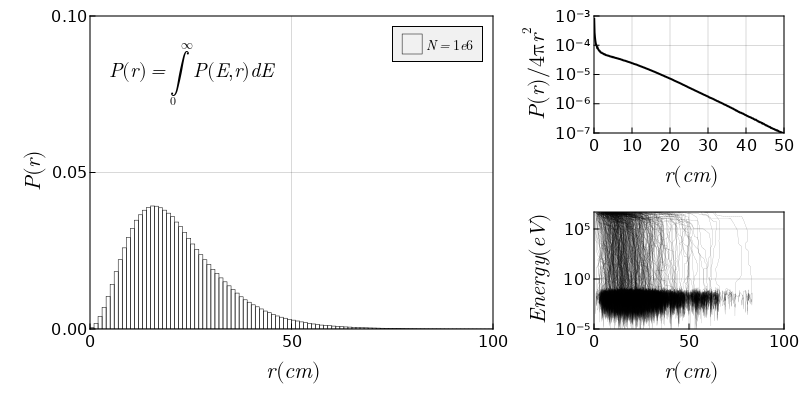

In [95]:

h = LinearAlgebra.normalize(fit(Histogram, vcat(listrho...),LinRange(0,100,1011)))
midpoint = collect(0.5.*(h.edges[1][2:end].+ h.edges[1][1:end-1]))
ypoint = h.weights

fig = Figure(resolution = (800,400))
ax = Axis(fig[1:2,1:2],
ylabel = L"P(r)",xlabel =L"r (cm)",
limits = (0,100,0,0.1),
)

hist!(vcat(listrho...),bins = range(0,100,101),normalization = :pdf, offset = 0, 
strokewidth = .5, color = :transparent, strokecolor = :black,label = L"N = 1e6")

text!(L"$P(r) = \int_0^{\infty} P(E,r)dE$",position = (5, 0.07), color = :black)

axislegend(position = :rt, bgcolor = (:grey90, 0.55));

ax = Axis(fig[1,3],
yscale=log10,
# xscale=log10,
# yticks = [1e-10,1e-6,1e-2],
xlabel = L"r (cm)", ylabel=L"$P(r)/4πr^2$",
limits = (0.,50,1e-7,1e-3)
)

lines!(midpoint,ypoint ./ (4π .* midpoint .^ 2), color = :black, linewidth = 2)
# lines!(midpoint,0.01 ./ (4π .* midpoint .^ 2), linewidth = 2)

ax = Axis(fig[2,3],
yscale=log10,
limits=(0,100,1e-5,5e6),
xlabel = L"r(cm)",ylabel=L"Energy (eV)"
)

for i in 1:1:500
    lines!(listrho[i],listE[i], color = :black,linewidth = .1)
end
fig

# save("Distribution_distances_3.pdf",fig)

Here I filter the energies at a given cut-off value of the distance r, hence $P(E,x>r)$.

Next, I filter the empty lists and I filter for energies above 1eV.

In [96]:
list_energies_cutoff_0cm,list_energies_cutoff_10cm,list_energies_cutoff_20cm = [],[],[]
list_energies_cutoff_30cm,list_energies_cutoff_40cm,list_energies_cutoff_50cm = [],[],[]

#filter energies with condition that ρ> x cm. I.e. we want to explore the distribution of the energies at a certain distance.
#How many neutrons still have the (almost) initial energy after reaching x cm.

for i in 1:1:length(listrho)
    E_rho_ll_0 = listE[i][listrho[i] .> 0]
    E_rho_ll_10 = listE[i][listrho[i] .> 10]
    E_rho_ll_20 = listE[i][listrho[i] .> 20]
    E_rho_ll_30 = listE[i][listrho[i] .> 30]
    E_rho_ll_40 = listE[i][listrho[i] .> 40]
    E_rho_ll_50 = listE[i][listrho[i] .> 50]
    push!(list_energies_cutoff_0cm,(E_rho_ll_0));push!(list_energies_cutoff_10cm,(E_rho_ll_10));
    push!(list_energies_cutoff_20cm,(E_rho_ll_20));push!(list_energies_cutoff_30cm,(E_rho_ll_30));
    push!(list_energies_cutoff_40cm,(E_rho_ll_40));push!(list_energies_cutoff_50cm,(E_rho_ll_50));
end

nonemptyElist0 = filter(!isempty,list_energies_cutoff_0cm)
nonemptyElist10 = filter(!isempty,list_energies_cutoff_10cm)
nonemptyElist20 = filter(!isempty,list_energies_cutoff_20cm)
nonemptyElist30 = filter(!isempty,list_energies_cutoff_30cm)
nonemptyElist40 = filter(!isempty,list_energies_cutoff_40cm)
nonemptyElist50 = filter(!isempty,list_energies_cutoff_50cm)

E_ll_1ev_0cm = filter(!isempty,[nonemptyElist0[i][nonemptyElist0[i] .> 1e0] for i in 1:1:length(nonemptyElist0)]);
E_ll_1ev_10cm = filter(!isempty,[nonemptyElist10[i][nonemptyElist10[i] .> 1e0] for i in 1:1:length(nonemptyElist10)]);
E_ll_1ev_20cm = filter(!isempty,[nonemptyElist20[i][nonemptyElist20[i] .> 1e0] for i in 1:1:length(nonemptyElist20)]);
E_ll_1ev_30cm = filter(!isempty,[nonemptyElist30[i][nonemptyElist30[i] .> 1e0] for i in 1:1:length(nonemptyElist30)]);
E_ll_1ev_40cm = filter(!isempty,[nonemptyElist40[i][nonemptyElist40[i] .> 1e0] for i in 1:1:length(nonemptyElist40)]);
E_ll_1ev_50cm = filter(!isempty,[nonemptyElist50[i][nonemptyElist50[i] .> 1e0] for i in 1:1:length(nonemptyElist50)]);



Here I plot the result. I Plot the denisty distribution P(d) for different values of the cut-off distance. A cut-off distance of x cm means that any particle at any point in time (collision number) that has a distance larger than x cm is included in the distribution. If we are interested in the energy distribution of the neutrons after 30 cm, we set x=30 cm.

Furthermore, since the energies of the neutrons is mostly thermal, we make a second cut in the distribution. The last filter filters the energy E larger than 1 eV. This is an arbitrary cut-off, but in this case it filters out the thermal neutrons.

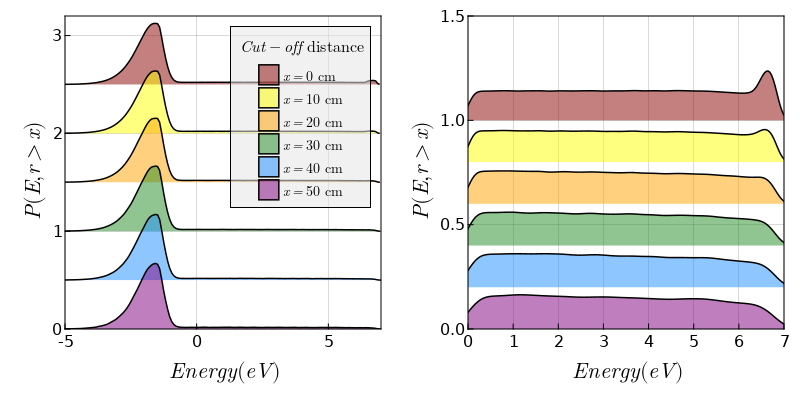

In [68]:
fig = Figure(resolution=(800,400))
ax = Axis(fig[1,1],
# xscale = log10,
xlabel = L"Energy (eV)",ylabel=L"P(E,r>x)",
limits=(-5,7,0,3.2)
)
density!(log10.(vcat(filter(!isempty,list_energies_cutoff_0cm)...)), offset = 2.5, strokewidth = 1.5,
strokecolor = :black,color = (:darkred,0.5), label = L"$x = 0$ cm")
density!(log10.(vcat(filter(!isempty,list_energies_cutoff_10cm)...)), offset = 2, strokewidth = 1.5,
strokecolor = :black,color = (:yellow,0.5), label = L"$x = 10$ cm")
density!(log10.(vcat(filter(!isempty,list_energies_cutoff_20cm)...)), offset = 1.5, strokewidth = 1.5,
strokecolor = :black,color = (:orange,0.5), label = L"$x = 20$ cm")
density!(log10.(vcat(filter(!isempty,list_energies_cutoff_30cm)...)), offset = 1, strokewidth = 1.5,
strokecolor = :black,color = (:forestgreen,0.5), label = L"$x = 30$ cm")
density!(log10.(vcat(filter(!isempty,list_energies_cutoff_40cm)...)), offset = 0.5, strokewidth = 1.5,
strokecolor = :black,color = (:dodgerblue,0.5), label = L"$x = 40$ cm")
density!(log10.(vcat(filter(!isempty,list_energies_cutoff_50cm)...)), offset = 0, strokewidth = 1.5,
strokecolor = :black,color = (:purple,0.5), label = L"$x = 50$ cm")


axislegend(L"$Cut-off$ distance", position = :rt, bgcolor = (:grey90, 0.55));

ax = Axis(fig[1,2],
# xscale = log10,
xlabel = L"Energy (eV)",ylabel=L"P(E,r>x)",
limits=(0,7,0,1.5)
)
density!(log10.(vcat(E_ll_1ev_0cm...)), offset = 1, strokewidth = 1.5,
strokecolor = :black,color = (:darkred,0.5), label = L"$x = 0$ cm")

density!(log10.(vcat(E_ll_1ev_10cm...)), offset = 0.8, strokewidth = 1.5,
strokecolor = :black,color = (:yellow,0.5), label = L"$x = 10$ cm")

density!(log10.(vcat(E_ll_1ev_20cm...)), offset = 0.6, strokewidth = 1.5,
strokecolor = :black,color = (:orange,0.5), label = L"$x = 20$ cm")

density!(log10.(vcat(E_ll_1ev_30cm...)), offset = 0.4, strokewidth = 1.5,
strokecolor = :black,color = (:forestgreen,0.5), label = L"$x = 30$ cm")

density!(log10.(vcat(E_ll_1ev_40cm...)), offset = 0.2, strokewidth = 1.5,
strokecolor = :black,color = (:dodgerblue,0.5), label = L"$x = 40$ cm")

density!(log10.(vcat(E_ll_1ev_50cm...)), offset = 0, strokewidth = 1.5,
strokecolor = :black,color = (:purple,0.5), label = L"$x = 50$ cm")

# axislegend(L"$Cut-off$ distance", position = :rt, bgcolor = (:grey90, 0.55));

fig

The previous graphs shows that the distribution of the energies give a certain distance d is independent of the distance d (up to a certain extend). This means that if we know the full distribution for every d, we also know the distribution of energies any given distance d. Still, we need to account for elastic inelastic collisions: a neutron is more likely to be detected close to the source than far away. We can calculate the detection difference by assuming a linear scaling relation. 

The scaling relation is calculated by calculating the total number of events that exceed a certain distance d. At the origin the total of number of neutrons detected is $N_0$, but at a distance d we have $N(d)$ < $N_0$. Hence,

$N_{scaling}(d) =\frac{N(d)}{N_0}$



In [103]:
scaling= []
for j in 1:1:120
    cutoff = []
    for i in 1:1:50000
        E_rho = listE[i][listrho[i] .> j]
        append!(cutoff,(E_rho))
    end
    append!(scaling, length(vcat(cutoff...)))
end

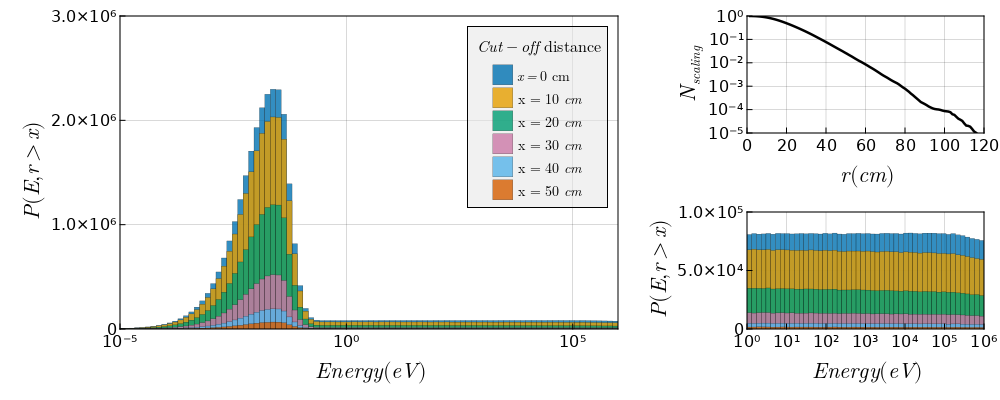

In [104]:
fig = Figure(resolution=(1000,400))
ax = Axis(fig[1:2,1:2],
xscale = log10,
xlabel = L"Energy (eV)",ylabel=L"P(E,r>x)",
limits=(1e-5,1e6,0,3e6)
)
hist!(vcat(filter(!isempty,list_energies_cutoff_0cm)...),bins = NF.logrange(-6,6,101), offset = 0, 
strokewidth = 0.2, strokecolor = :black,label = L"$x = 0$ cm")
hist!(vcat(filter(!isempty,list_energies_cutoff_10cm)...),bins = NF.logrange(-6,6,101), offset = 0, 
strokewidth = 0.2, strokecolor = :black,label = L"x = 10 $cm$")
hist!(vcat(filter(!isempty,list_energies_cutoff_20cm)...),bins = NF.logrange(-6,6,101), offset = 0, 
strokewidth = 0.2, strokecolor = :black,label = L"x = 20 $cm$")
hist!(vcat(filter(!isempty,list_energies_cutoff_30cm)...),bins = NF.logrange(-6,6,101), offset = 0, 
strokewidth = 0.2, strokecolor = :black,label = L"x = 30 $cm$")
hist!(vcat(filter(!isempty,list_energies_cutoff_40cm)...),bins = NF.logrange(-6,6,101),offset = 0, 
strokewidth = 0.2, strokecolor = :black,label = L"x = 40 $cm$")
hist!(vcat(filter(!isempty,list_energies_cutoff_50cm)...),bins = NF.logrange(-6,6,101), offset = 0, 
strokewidth = 0.2, strokecolor = :black,label = L"x = 50 $cm$")

axislegend(L"$Cut-off$ distance", position = :rt, bgcolor = (:grey90, 0.55));


ax = Axis(fig[1,3],
yscale=log10,
xlabel = L"r (cm)",ylabel=L"$N_{scaling}$",
limits=(0,120,1e-5,1))
lines!(Float64.(scaling)./scaling[1],color = :black, linewidth =2.5)

ax = Axis(fig[2,3],
xscale = log10,
xlabel = L"Energy (eV)",ylabel=L"P(E,r>x)",
limits=(1e0,1e6,0,1.e5)
)

hist!(vcat(E_ll_1ev_0cm...),bins = NF.logrange(0,6,51),strokewidth = 0.2, strokecolor = :black,label = L"$x = 0$ cm")
hist!(vcat(E_ll_1ev_10cm...),bins = NF.logrange(0,6,51), strokewidth = 0.2,strokecolor = :black,label = L"x = 10 $cm$")
hist!(vcat(E_ll_1ev_20cm...),bins = NF.logrange(0,6,51), strokewidth = 0.2,strokecolor = :black,label = L"x = 20 $cm$")
hist!(vcat(E_ll_1ev_30cm...),bins = NF.logrange(0,6,51), strokewidth = 0.2,strokecolor = :black,label = L"x = 30 $cm$")
hist!(vcat(E_ll_1ev_40cm...),bins = NF.logrange(0,6,51), strokewidth = 0.2,strokecolor = :black,label = L"x = 40 $cm$")
hist!(vcat(E_ll_1ev_50cm...),bins = NF.logrange(0,6,51), strokewidth = 0.2,strokecolor = :black,label = L"x = 50 $cm$")

fig

# save("P_E_r_5_distances.pdf",fig)

In the next lines I take a closer look at the fraction of events that is larger than x eV. I filter the data at 6 different distances (0, 10, 20, 30, 40, 50 cm) and filter (again) at the energy cut-off. 

In [105]:
# calculates the fraction of energies above the theshhold at a given distance.
energylist = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1e0,5e0,1e1,5e1,1e2,5e2,1e3,5e3,1e4,5e4,1e5,5e5,1e6]
list_frac_0 = [length(vcat(filter(!isempty,[nonemptyElist0[i][nonemptyElist0[i] .> j] for i in 1:1:length(nonemptyElist0)])...))/length(vcat(nonemptyElist0...)) for j in energylist];
list_frac_10 = [length(vcat(filter(!isempty,[nonemptyElist10[i][nonemptyElist10[i] .> j] for i in 1:1:length(nonemptyElist10)])...))/length(vcat(nonemptyElist10...)) for j in energylist];
list_frac_20 = [length(vcat(filter(!isempty,[nonemptyElist20[i][nonemptyElist20[i] .> j] for i in 1:1:length(nonemptyElist20)])...))/length(vcat(nonemptyElist20...)) for j in energylist];
list_frac_30 = [length(vcat(filter(!isempty,[nonemptyElist30[i][nonemptyElist30[i] .> j] for i in 1:1:length(nonemptyElist30)])...))/length(vcat(nonemptyElist30...)) for j in energylist];
list_frac_40 = [length(vcat(filter(!isempty,[nonemptyElist40[i][nonemptyElist40[i] .> j] for i in 1:1:length(nonemptyElist40)])...))/length(vcat(nonemptyElist40...)) for j in energylist];
list_frac_50 = [length(vcat(filter(!isempty,[nonemptyElist50[i][nonemptyElist50[i] .> j] for i in 1:1:length(nonemptyElist50)])...))/length(vcat(nonemptyElist50...)) for j in energylist];

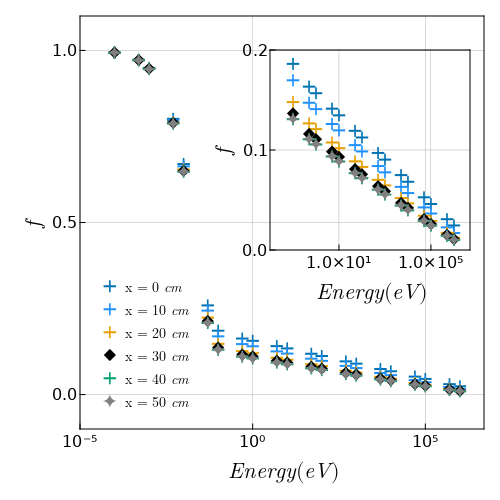

In [106]:
fig = Figure(resolution=(500,500))
ax = Axis(fig[1,1],
xscale = log10,
xlabel = L"Energy (eV)",ylabel=L"f",
limits=(1e-5,5e6,-0.1,1.1)
)

scatter!(ax,energylist,list_frac_0,marker = :+,markersize=20,label = L"x = 0 $cm$")
scatter!(energylist,list_frac_10,marker = :+,markersize=20,label = L"x = 10 $cm$",color=:dodgerblue)
scatter!(energylist,list_frac_20,marker = :+,markersize=20,label = L"x = 20 $cm$")
scatter!(energylist,list_frac_30,marker = :diamond,markersize=16,label = L"x = 30 $cm$",color=:black)
scatter!(energylist,list_frac_40,marker = :+,markersize=20,label = L"x = 40 $cm$")
scatter!(energylist,list_frac_50,marker = :star4,markersize=20,label = L"x = 50 $cm$",color=:gray)

axislegend(position = :lb,framevisible=false);

# f[1, 2:4] = legends[1:3]

ax2 = Axis(fig, bbox = BBox(270, 470, 250, 450), 
xticklabelsize = 16,yticklabelsize = 16,
xlabel = L"$Energy (eV)$",ylabel = ylabel=L"f",
xscale=log10,
limits=(1e-2,5e6,0,0.2),
xticks = [1e1,1e5],
yticks = [0,0.1,0.2],
)
scatter!(ax2,energylist,list_frac_0,marker = :+,markersize=20)
scatter!(ax2,energylist,list_frac_10,marker = :+,markersize=20,color=:dodgerblue)
scatter!(ax2,energylist,list_frac_20,marker = :+,markersize=20)
scatter!(ax2,energylist,list_frac_30,marker = :diamond,markersize=16,color=:black)
scatter!(ax2,energylist,list_frac_40,marker = :+,markersize=20)
scatter!(ax2,energylist,list_frac_50,marker = :star4,markersize=20,color=:gray)

fig

# save("Fraction_energies_rho_cutoff.pdf",fig)

## Flux Calculation
In this section I calculate the flux of a particles.

We define the flux as the number of times the particles passes through an imaginary surface at radius r. Since the particles follow (roughly) Brownian motion a single particle can surpass the surface multiple times. The direction can have two signs: 1) outward flux ($\phi_r$ right-sided) and inward flux ($\phi_l$ left-sided).

The total flux $\phi_t$ is the sum of both $\phi_t = \phi_r + \phi_l$. The netto flux $\phi_n$, i.e. the difference between $\phi_n = \phi_r-\phi_r$ is ofcourse equal to the total number of particles. However, due to fission reactions, the netto flux is not equal to the total number of particles at a given distance r. This is only true for r = 0.

The flux is position dependent and fall or with the inverse square law. We calculate the irradiance by:

$\tilde{\phi} = \phi_t / 4\pi r^2$

For a practical calculation we assume a surface area of $A = 25 cm^2$ and a total number of particles of $10^7$. The total number of neutrons released by the source is in the order of $10^7 neutrons/s$. This is the irradiance for 1 second at a distance r.


In [110]:
flux_total_list_r,flux_total_list_l,flux_total_list_t = [],[],[]

for j in 1:1:50000
    if j%10000 == 0
        println(j)
    end
    flux_single_l = [SM.flux_single_run_left(listrho[j],i) for i in 0:.1:120]
    flux_single_r = [SM.flux_single_run_right(listrho[j],i) for i in 0:.1:120]
    flux_single_t = [SM.flux_total(listrho[j],i) for i in 0:.1:120]

    push!(flux_total_list_r,flux_single_r)
    push!(flux_total_list_l,flux_single_l)
    push!(flux_total_list_t,flux_single_t)

end

mean_flux_l = mean(flux_total_list_l);
mean_flux_r = mean(flux_total_list_r);
mean_flux_t = mean(flux_total_list_t);

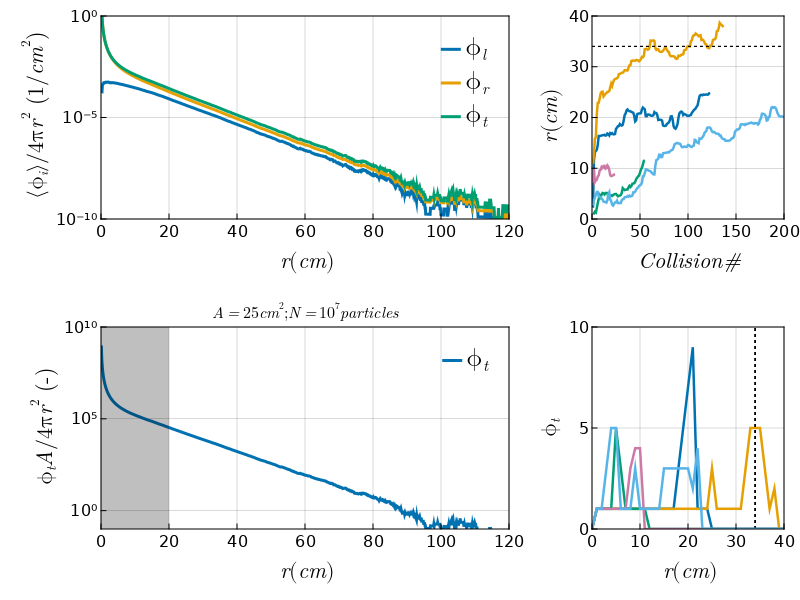

In [111]:
fig = Figure(resolution=(800,600))
ax = Axis(fig[1,1:2],
yscale=log10,
ylabel = L"$⟨ϕ_i⟩/4πr^2$ ($1/cm^2$)",xlabel=L"r(cm)",
limits=(0,120,1e-10,1)
)
lines!(LinRange(0,120,1201),mean_flux_l ./ (4π .* LinRange(0,120,1201).^2 ), label = L"ϕ_l",linewidth=3)
lines!(LinRange(0,120,1201),mean_flux_r./ (4π .* LinRange(0,120,1201).^2 ), label = L"ϕ_r",linewidth=3)
lines!(LinRange(0,120,1201),mean_flux_t./ (4π .* LinRange(0,120,1201).^2 ), label = L"ϕ_t",linewidth=3)
axislegend(position = :rt,framevisible=false,labelsize=26);

ax = Axis(fig[2,1:2],
title=L"A = 25 cm^2; N = 10^7 particles",
yscale=log10,
ylabel = L"$ϕ_t A/4πr^2$ (-)",xlabel=L"r(cm)",
limits=(0,120,1e-1,1e10)
)
lines!(LinRange(0,120,1201),100*25*sum(flux_total_list_t) ./ (4π .* LinRange(0,120,1201).^2 ), label = L"$ϕ_t$",linewidth=3)

band!(LinRange(0,20,21),1e-5,1e10; color = (:black, 0.25), diffuse=0.5)

axislegend(position = :rt,framevisible=false,labelsize=26);


ax = Axis(fig[1,3],
ylabel = L"r(cm)",xlabel=L"Collision #",
limits = (0,200,0,40)
)
for i in 1:1:5
    lines!(listrho[i],linewidth =2.5)
    hlines!(ax,34, color = :black,linestyle=:dash,linewidth=1)
end

ax = Axis(fig[2,3],
ylabel = L"ϕ_t",xlabel=L"r (cm)",
limits = (0,40,0,10)
)
for j in 1:1:5
    vlines!(ax,34, color = :black,linestyle=:dash,linewidth=1)
    lines!(LinRange(0,40,41),[flux_total(listrho[j],i) for i in 0:1:40],linewidth =2.5)
end
fig

# save("irradiance.pdf",fig)


\begin{align}
something & \\
smething else \tag{2}
\end{align}

\ref{2}